In [1]:
# Connect to Google Colab VM, if execute locally, ignore this cell.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Before Loading

## Load validation set

In [2]:
# Change the path of Val/Yes folder.
img_root = '/content/drive/My Drive/BraTs/Val/Yes/'

## Import packages

In [3]:
import numpy as np 
from tqdm import tqdm
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import shutil
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Define Data Generator

In [4]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, dim=(240,240), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(list_IDs_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 1))
        Y = np.empty((self.batch_size, *self.dim, 2))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # Add data augmentation here
            img = np.load(ID)[:,:,0]
            img = np.expand_dims(img, axis=2)
            X[i,] = img

            # Store class
            label = np.load(ID.split('_')[0]+'_seg.npy')
            label = np.expand_dims(label, axis=2)
            label = np.concatenate(((-label)+1, label),axis=-1)
            Y[i,] = label

        return X, Y

## Define metrics and loss function

In [5]:
def dice_coef(y_true, y_pred, smooth=1.0):
    ''' Dice Coefficient
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''
    class_num = 2
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


def dice_coef_loss(y_true, y_pred):
    ''' Dice Coefficient Loss
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''
    return 1 - dice_coef(y_true, y_pred)

def tversky(y_true, y_pred, alpha=0.7):
    smooth = 1
    class_num = 2
    for i in range (class_num):  
        y_true_pos = K.flatten(y_true[:,:,:,i])
        y_pred_pos = K.flatten(y_pred[:,:,:,i])
        true_pos = K.sum(y_true_pos * y_pred_pos)
        false_neg = K.sum(y_true_pos * (1-y_pred_pos))
        false_pos = K.sum((1-y_true_pos)*y_pred_pos)
        loss = (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def log_cosh_dice_loss(y_true, y_pred):
        x = dice_coef_loss(y_true, y_pred)
        return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

# Load the model


*   Model 1: U-net with Leaky ReLU, validation dice coefficient: 92.5%
*   Model 2: U-net, validation dice coefficient: 88%?
*   Model 3: Residue U-net, validation dice coefficient: 91.81%



## Model 1
Load the model with Leaky ReLU. Prepare *'BrainTumourPredictor_weight.h5'* for loading.

In [6]:
from keras import initializers

input_size = (240,240,1)

lrelu = Lambda(lambda x: tf.keras.activations.relu(x, alpha=0.1))

inputs = Input(input_size)
conv1 = Conv2D(32, (3, 3), activation=lrelu, padding='same',
                kernel_initializer=initializers.random_normal(stddev=0.01))(inputs)
conv1 = Conv2D(32, (3, 3), activation=lrelu, padding='same',
                kernel_initializer=initializers.random_normal(stddev=0.01))(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation=lrelu, padding='same',
                kernel_initializer=initializers.random_normal(stddev=0.01))(pool1)
conv2 = Conv2D(64, (3, 3), activation=lrelu, padding='same',
                kernel_initializer=initializers.random_normal(stddev=0.01))(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation=lrelu, padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(pool2)
conv3 = Conv2D(128, (3, 3), activation=lrelu, padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation=lrelu, padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(pool3)
conv4 = Conv2D(256, (3, 3), activation=lrelu, padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation=lrelu, padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(pool4)
conv5 = Conv2D(512, (3, 3), activation=lrelu, padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same',
            kernel_initializer=initializers.random_normal(stddev=0.1))(conv5),conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation=lrelu, padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.0))(up6)
conv6 = Conv2D(256, (3, 3), activation=lrelu, padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same',
            kernel_initializer=initializers.random_normal(stddev=0.01))(conv6),conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation=lrelu, padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(up7)
conv7 = Conv2D(128, (3, 3), activation=lrelu, padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2),padding='same',
            kernel_initializer=initializers.random_normal(stddev=0.01))(conv7),conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation=lrelu, padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(up8)
conv8 = Conv2D(64, (3, 3), activation=lrelu, padding='same',)(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same',
            kernel_initializer=initializers.random_normal(stddev=0.01))(conv8),conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation=lrelu, padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(up9)
conv9 = Conv2D(32, (3, 3), activation=lrelu, padding='same',
               kernel_initializer=initializers.random_normal(stddev=0.01))(conv9)

conv10 = Conv2D(2, (1, 1), activation=lrelu,
                kernel_initializer=initializers.random_normal(stddev=0.01))(conv9)
conv10 = Activation('softmax')(conv10)
model1 = Model(inputs=[inputs], outputs=[conv10])

try:
    lr = args.lr
except:
    lr = 1e-4
model1.compile(optimizer=Adam(lr=lr), loss=log_cosh_dice_loss, metrics=[dice_coef])

# Load weights. Change the path of BrainTumourPredictor_weight.h5 file here.
model1.load_weights('/content/drive/MyDrive/BraTs/BrainTumourPredictor_weight.h5')  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Test for Model 1.

Input size, Should be (1, 240, 240, 1):
(1, 240, 240, 1)
Output size, Should be (1, 240, 240, 2):
(1, 240, 240, 2)
Dice coefficient:
tf.Tensor(0.50868595, shape=(), dtype=float32)


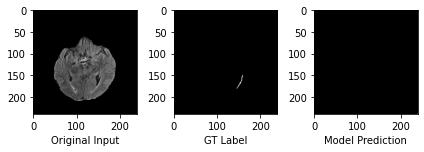

In [7]:
img_size = (240,240)
all_files = os.listdir(img_root)
files = [item for item in all_files if "img" in item]
random.shuffle(files)
test_list = []
x_test = np.load(os.path.join(img_root,files[0]))
x_seg = np.load(os.path.join(img_root,files[0]).split('_')[0]+'_seg.npy')
test_list.append(os.path.join(img_root,files[0]))
test_generator = DataGenerator(test_list, batch_size=1)
x_test2, y = test_generator.__getitem__(0)
print('Input size, Should be (1, 240, 240, 1):') 
print(x_test2.shape)
prediction = model1.predict(x_test2)
print('Output size, Should be (1, 240, 240, 2):') 
print(prediction.shape)

plt.subplot(1,3,1)
plt.imshow(x_test2[0,:,:,0], cmap='gray')
plt.xlabel('Original Input')
plt.subplot(1,3,2)
plt.imshow(x_seg, cmap='gray')
plt.xlabel('GT Label')
plt.subplot(1,3,3)
plt.imshow(prediction[0,:,:,1], cmap='gray')
plt.xlabel('Model Prediction')
plt.tight_layout()

y = y.astype('float32')
print('Dice coefficient:')
print(dice_coef(y,prediction))

## Model 2
Load the model U-net. Prepare *'trained_model_epoch6.h5'* for loading.

In [8]:
# Load model. Change the path of trained_model_epoch6.h5 file here.
model2 = load_model('/content/drive/MyDrive/BraTs/trained_model_epoch6.h5',custom_objects={'log_cosh_dice_loss': log_cosh_dice_loss,'dice_coef':dice_coef})

Test for Model 2.

Input size, Should be (1, 240, 240, 1):
(1, 240, 240, 1)
Output size, Should be (1, 240, 240, 2):
(1, 240, 240, 2)
Dice coefficient:
tf.Tensor(0.79974306, shape=(), dtype=float32)


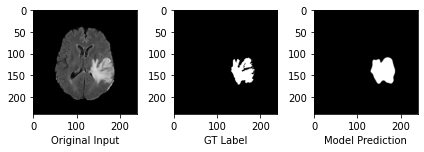

In [9]:
img_size = (240,240)
all_files = os.listdir(img_root)
files = [item for item in all_files if "img" in item]
random.shuffle(files)
test_list = []
x_test = np.load(os.path.join(img_root,files[0]))
x_seg = np.load(os.path.join(img_root,files[0]).split('_')[0]+'_seg.npy')
test_list.append(os.path.join(img_root,files[0]))
test_generator = DataGenerator(test_list, batch_size=1)
x_test2, y = test_generator.__getitem__(0)
print('Input size, Should be (1, 240, 240, 1):') 
print(x_test2.shape)
prediction = model2.predict(x_test2)
print('Output size, Should be (1, 240, 240, 2):') 
print(prediction.shape)

plt.subplot(1,3,1)
plt.imshow(x_test2[0,:,:,0], cmap='gray')
plt.xlabel('Original Input')
plt.subplot(1,3,2)
plt.imshow(x_seg, cmap='gray')
plt.xlabel('GT Label')
plt.subplot(1,3,3)
plt.imshow(prediction[0,:,:,1], cmap='gray')
plt.xlabel('Model Prediction')
plt.tight_layout()

y = y.astype('float32')
print('Dice coefficient:')
print(dice_coef(y,prediction))

## Model 3
Load the model Residue U-net. Prepare *'Res-Unet_weights.h5'* for loading.

In [10]:
class ResBlock(Layer):
    """
    Represents the Residual Block in the ResUNet architecture.
    """
    def __init__(self, filters, strides, **kwargs):
        super(ResBlock, self).__init__(**kwargs)
        self.filters = filters
        self.strides = strides

        self.bn1 = BatchNormalization()
        self.relu1 = ReLU()
        self.conv1 = Conv2D(filters=filters, kernel_size=3, strides=strides, padding="same", use_bias=False)

        self.bn2 = BatchNormalization()
        self.relu2 = ReLU()
        self.conv2 = Conv2D(filters=filters, kernel_size=3, strides=1, padding="same", use_bias=False)

        self.conv_skip = Conv2D(filters=filters, kernel_size=1, strides=strides, padding="same", use_bias=False)
        self.bn_skip = BatchNormalization()

        self.add = Add()

    def call(self, inputs, training=False, **kwargs):
        x = inputs
        x = self.bn1(x, training=training)
        x = self.relu1(x)
        x = self.conv1(x)

        x = self.bn2(x, training=training)
        x = self.relu2(x)
        x = self.conv2(x)

        skip = self.conv_skip(inputs)
        skip = self.bn_skip(skip, training=training)

        res = self.add([x, skip])
        return res

In [11]:
def ResUNet(input_shape, classes: int, filters_root: int = 64, depth: int = 3):

    input = Input(shape=input_shape)

    layer = input

    # ENCODER
    encoder_blocks = []

    filters = filters_root
    layer = Conv2D(filters=filters, kernel_size=3, strides=1, padding="same")(layer)

    branch = Conv2D(filters=filters, kernel_size=3, strides=1, padding="same", use_bias=False)(layer)
    branch = BatchNormalization()(branch)
    branch = ReLU()(branch)
    branch = Conv2D(filters=filters, kernel_size=3, strides=1, padding="same", use_bias=True)(branch)
    layer = Add()([branch, layer])

    encoder_blocks.append(layer)

    for _ in range(depth - 1):
        filters *= 2
        layer = ResBlock(filters, strides=2)(layer)

        encoder_blocks.append(layer)

    # BRIDGE
    filters *= 2
    layer = ResBlock(filters, strides=2)(layer)

    # DECODER
    for i in range(1, depth + 1):
        filters //= 2
        skip_block_connection = encoder_blocks[-i]

        layer = UpSampling2D()(layer)
        layer = Concatenate()([layer, skip_block_connection])
        layer = ResBlock(filters, strides=1)(layer)

    layer = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same")(layer)
    layer = Softmax()(layer)

    output = layer

    return Model(input, output)

In [12]:
import keras

model3 = ResUNet((240,240,1),2)

try:
    lr = args.lr
except:
    lr = 1e-3
model3.compile(optimizer=Adam(lr=lr), loss=log_cosh_dice_loss, metrics=[dice_coef])

# Load weights. Change the path of Res-Unet_weights.h5 file here.
model3.load_weights('/content/drive/MyDrive/BraTs/Res-Unet_weights.h5')  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Test for Model 3.

Input size, Should be (1, 240, 240, 1):
(1, 240, 240, 1)
Output size, Should be (1, 240, 240, 2):
(1, 240, 240, 2)
Dice coefficient:
tf.Tensor(0.9782458, shape=(), dtype=float32)


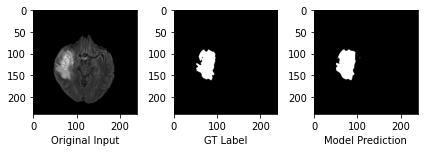

In [13]:
img_size = (240,240)
all_files = os.listdir(img_root)
files = [item for item in all_files if "img" in item]
random.shuffle(files)
test_list = []
x_test = np.load(os.path.join(img_root,files[0]))
x_seg = np.load(os.path.join(img_root,files[0]).split('_')[0]+'_seg.npy')
test_list.append(os.path.join(img_root,files[0]))
test_generator = DataGenerator(test_list, batch_size=1)
x_test2, y = test_generator.__getitem__(0)
print('Input size, Should be (1, 240, 240, 1):') 
print(x_test2.shape)
prediction = model3.predict(x_test2)
print('Output size, Should be (1, 240, 240, 2):') 
print(prediction.shape)

plt.subplot(1,3,1)
plt.imshow(x_test2[0,:,:,0], cmap='gray')
plt.xlabel('Original Input')
plt.subplot(1,3,2)
plt.imshow(x_seg, cmap='gray')
plt.xlabel('GT Label')
plt.subplot(1,3,3)
plt.imshow(prediction[0,:,:,1], cmap='gray')
plt.xlabel('Model Prediction')
plt.tight_layout()

y = y.astype('float32')
print('Dice coefficient:')
print(dice_coef(y,prediction))

# Summary and Comparison
Use the same input for test, compare the models.

Model List:
*   Model 1: U-net with Leaky ReLU, validation dice coefficient: 92.5%
*   Model 2: U-net, validation dice coefficient: 88%?
*   Model 3: Residue U-net, validation dice coefficient: 91.81%

Dice coefficient for Model 1:
tf.Tensor(0.9811511, shape=(), dtype=float32)
Dice coefficient for Model 2:
tf.Tensor(0.7245754, shape=(), dtype=float32)
Dice coefficient for Model 3:
tf.Tensor(0.9316555, shape=(), dtype=float32)


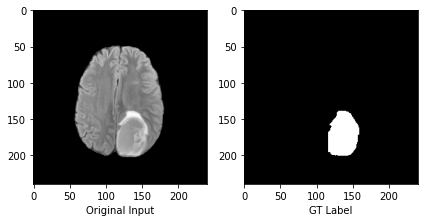

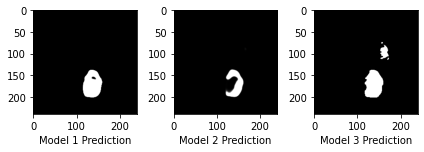

In [14]:
# Change the path of Val/Yes folder.
img_root = '/content/drive/My Drive/BraTs/Val/Yes/'

img_size = (240,240)
all_files = os.listdir(img_root)
files = [item for item in all_files if "img" in item]
random.shuffle(files)
test_list = []
x_test = np.load(os.path.join(img_root,files[0]))
x_seg = np.load(os.path.join(img_root,files[0]).split('_')[0]+'_seg.npy')
test_list.append(os.path.join(img_root,files[0]))
test_generator = DataGenerator(test_list, batch_size=1)
x_test2, y = test_generator.__getitem__(0)
prediction1 = model1.predict(x_test2)
prediction2 = model2.predict(x_test2)
prediction3 = model3.predict(x_test2)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(x_test2[0,:,:,0], cmap='gray')
plt.xlabel('Original Input')
plt.subplot(1,2,2)
plt.imshow(x_seg, cmap='gray')
plt.xlabel('GT Label')
plt.tight_layout()
plt.figure()
plt.subplot(1,3,1)
plt.imshow(prediction1[0,:,:,1], cmap='gray')
plt.xlabel('Model 1 Prediction')
plt.subplot(1,3,2)
plt.imshow(prediction2[0,:,:,1], cmap='gray')
plt.xlabel('Model 2 Prediction')
plt.tight_layout()
plt.subplot(1,3,3)
plt.imshow(prediction3[0,:,:,1], cmap='gray')
plt.xlabel('Model 3 Prediction')
plt.tight_layout()

y = y.astype('float32')
print('Dice coefficient for Model 1:')
print(dice_coef(y,prediction1))
print('Dice coefficient for Model 2:')
print(dice_coef(y,prediction2))
print('Dice coefficient for Model 3:')
print(dice_coef(y,prediction3))